# Importing dataset
### We will be working on the classic mnist dataset

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


# Importing dependencies

In [3]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

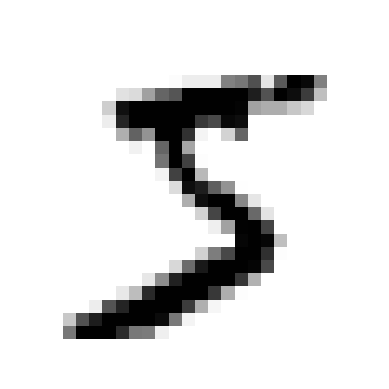

Rótulo: 5


In [4]:
some_digit = X.iloc[0].to_numpy()
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap = "binary")
plt.axis("off")
plt.show()
print("Rótulo:", y[0])

In [5]:
y = y.astype(np.uint8)

In [6]:
X_train, X_test, y_train, y_test = X[:60000],X[60000:],y[:60000],y[60000:]

# Classificador binário de algarismo 
### Este calssificador irá identificar se um número é 5 ou não


In [7]:
y_train_5 = (y_train == 5)
y_test_5 = (y_train == 5)


In [8]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)


SGDClassifier(random_state=42)

In [9]:
sgd_clf.predict([some_digit]) #some digit is a 5


c:\Users\Mateus\Documents\Meus Estudos\Aprendizado de Máquina\Livro_Mãos à Obra_OReilly\MLStudies_Classification_Repo\ML_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

# Working on how to evaluate classifiers

In [10]:
# including cross val analysis without using the sklearn cros_val_score function in order to have more in depth control
skfolds = StratifiedKFold(n_splits=3,random_state=42, shuffle=True)
for train_index, test_index in skfolds.split(X_train, y_train_5): # classifier for detecting written number 5, returns n_splits with 2 arrays each (X and y)
    #there will be 3 reps of the for function, one for each different split
    clone_clf = clone(sgd_clf) #clone function will clone the given predictor without its current fitting, pulling only the parameters (unfitted copy)
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_5[train_index]
    x_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train_5[test_index]
    clone_clf.fit(X_train_folds,y_train_folds) #fits the clone to new data
    y_pred = clone_clf.predict(x_test_fold)
    n_correct = sum(y_pred==y_test_fold) #compares True statements for predicted and real results for each fold
    print(n_correct/len(y_pred)) #will give us the % of right answers


0.9669
0.91625
0.96785


In [11]:
from sklearn.model_selection import cross_val_score

In [12]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

However, this result is unsatisfactory because we know that the proportion of 5s within the dataset is small, and therefore, any classifier that classifies everything as "not-5" would have a high accuracy performance.
Thus, accuracy is recognized as not being a good metric for evaluating classification models.

# Matriz de confunsão

In [13]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

In [14]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5,cv=3)


In [15]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [16]:
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))
print(f1_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311
0.7325171197343847


# Entendo o tradeoff entre precision e recall
#### Usando o método decision_function conseguimos adquirir o score relacionado a cada instância de algarismo desejada
O limiar padrão do SGDlassifier é 0, mas podemos usar dessa função para modificar esse padrão. Notamos que aumentar o limiar diminui o recall e naturalmente aumentará a precisão
 

In [19]:
y_scores = sgd_clf.decision_function([some_digit]) #sabemos que some_digit é 5
print("esse é o score" , y_scores)
threshold = 0
y_some_digit_pred = (y_scores>threshold)
print(f"dado o threshold {threshold}, a predição é: ",y_some_digit_pred)
threshold=8000
y_some_digit_pred = (y_scores>threshold)
print(f"dado o threshold {threshold}, a predição é: ",y_some_digit_pred)

esse é o score [2164.22030239]
dado o threshold 0, a predição é:  [ True]
dado o threshold 8000, a predição é:  [False]


c:\Users\Mateus\Documents\Meus Estudos\Aprendizado de Máquina\Livro_Mãos à Obra_OReilly\MLStudies_Classification_Repo\ML_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


Agora decidiremos qual limiar ou threshold utilizar para a função

In [20]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")


In [22]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [21]:
from sklearn.metrics import precision_recall_curve

In [24]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [27]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1])             
    
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

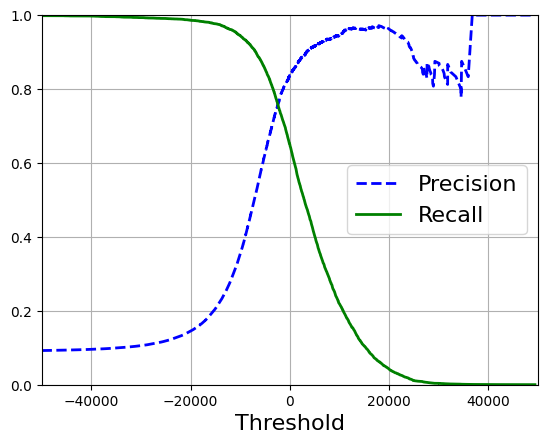

In [26]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

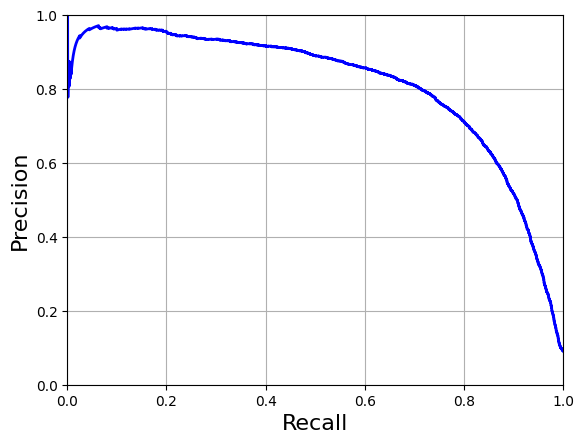

In [28]:
plot_precision_vs_recall(precisions, recalls)

In [41]:
threshold90prec = thresholds[np.argmax(precisions>=0.9)]
print("threshold: ", threshold90prec)
y_train_pred_90 = (y_scores >= threshold90prec)
print("precision is: ", precision_score(y_train_5, y_train_pred_90))
print("Recall is: ", recall_score(y_train_5, y_train_pred_90))

threshold:  3370.0194991439557
precision is:  0.9000345901072293
Recall is:  0.4799852425751706


Usando a curva ROC para conseguir um classificador mais balanceado

In [47]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [43]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)


In [44]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                     
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)         

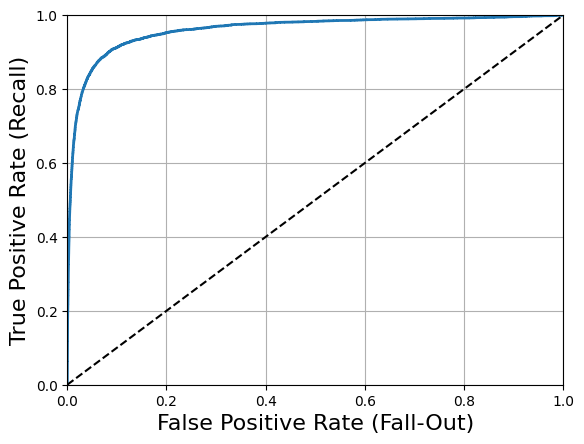

In [46]:
plot_roc_curve(fpr,tpr)

In [48]:
roc_auc_score(y_train_5,y_scores)

np.float64(0.9604938554008616)

Note no entanto que temos pouquissimos 5s no nosso dataset, assim, nosso FPR tende a ser muito baixo para altos recalls pois o número de true negatives é extremamente alto comparativamente

### agora compararemos o SGDClassifier a um modelo de random forest por meio dessas metricas que avaliamos

In [49]:
from sklearn.ensemble import RandomForestClassifier

In [50]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')


In [55]:
y_scores_forest = y_probas_forest[:,1] #gets the second column or class of each instance (positive proba)
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)


0.9983436731328145


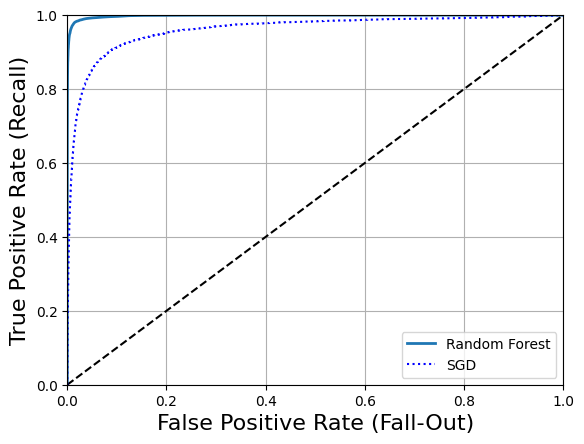

In [59]:
plot_roc_curve(fpr_forest,tpr_forest, "Random Forest")
plt.plot(fpr, tpr, "b:", label="SGD")
plt.legend(loc="lower right")
print(roc_auc_score(y_train_5, y_scores_forest))


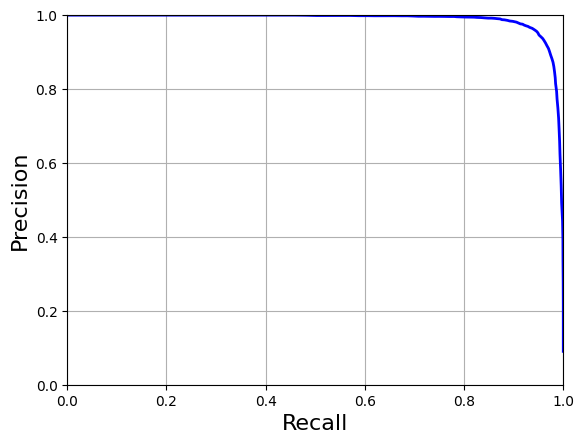

In [60]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores_forest)
plot_precision_vs_recall(precisions, recalls)

### Nota-se para o random forest classifier m desempenho superior ao SGD

# Evoluindo para um Classificador Multiclasse